In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, path):

        self.data = np.load(path, mmap_mode='r')

    def __getitem__(self, idx):

        image = self.data[idx]
        image = (image+1.0)*0.5
        image = image*255.0
        image = image.astype('uint8')
        pic = Image.fromarray(image)
        pic = pic.resize((32,32))

        image = np.array(pic, dtype=np.float32)
        pic.close()
        del pic

        image = image/127.5 - 1.0
        image = torch.from_numpy(image)
        image = image.view(image.size(2), image.size(0), image.size(1))

        return image

    def __len__(self):

        return len(self.data)

In [4]:
data = Dataset('D:/Python/Projects/Datasets/Complete_dataset.npy')

In [5]:
n_diffusion_timesteps = 1000
scale = 1000/n_diffusion_timesteps

beta_start = scale * 1e-4
beta_end = scale * 2e-2

beta = torch.linspace(beta_start, beta_end, n_diffusion_timesteps, dtype=torch.float32, device=device)

In [6]:
alpha = 1 - beta
sqrt_alpha = torch.sqrt(alpha)
alpha_cum = torch.cumprod(alpha, dim=0)
sqrt_alphacum = torch.sqrt(alpha_cum)
inverse_sqrtalpha = 1/sqrt_alpha
one_minus_alphacum = torch.sqrt(1 - alpha_cum)

In [7]:
def forward_diffusion(x0, timesteps):

    eps = torch.randn_like(x0) # Noise

    samples = []

    k = sqrt_alphacum[timesteps]
    m = one_minus_alphacum[timesteps]

    for i in range(len(x0)):

        mean = k[i].item() * x0[i] # Image scaled
        std = m[i].item() # Noise scaled

        sample = mean + std * eps[i]

        samples.append(sample.unsqueeze(0))
    
    samples = torch.cat(samples, 0)

    return samples, eps

In [8]:
def to_numpy(tensor):

    tensor = tensor.view(tensor.size(0), tensor.size(2), tensor.size(3), tensor.size(1))
    tensor = tensor.detach().cpu().numpy()
    tensor = (tensor+1.0)*0.5
    
    return tensor

In [78]:
teste = data.__getitem__(0).unsqueeze(0)

teste2, eps = forward_diffusion(teste.to(device), 600)

print(teste2.size())

teste, teste2 = to_numpy(teste), to_numpy(teste2)

plt.imshow(teste[0])
plt.show()

plt.imshow(teste2[0])
plt.show()

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [9]:
class ResidualBlock(torch.nn.Module):

    def __init__(self, input_channels, kernel_size, strides=1, padding=1):

        super(ResidualBlock, self).__init__()

        self.convA = torch.nn.Conv2d(input_channels, input_channels, kernel_size, strides, padding, bias=True)
        self.batchnormA = torch.nn.BatchNorm2d(input_channels)
        self.convB = torch.nn.Conv2d(input_channels, input_channels, kernel_size, strides, padding, bias=True)
        self.batchnormB = torch.nn.BatchNorm2d(input_channels)

        self.Relu = torch.nn.ReLU()

    def forward(self, input):

        x = self.convA(input)
        x = self.batchnormA(x)
        x = self.Relu(x)
        x = self.convB(x)
        x = self.batchnormB(x)

        output = input + x

        del x

        return output

In [10]:
class Diffusion(nn.Module):
    def __init__(self, n_diffusion_timesteps):
        super(Diffusion, self).__init__()

        self.embed = nn.Embedding(n_diffusion_timesteps, 3*32*32)

        self.conv1 = nn.Conv2d(6, 128, 3, 1, 1, bias=False) # 32x32
        self.resblock1 = ResidualBlock(128, 3, 1, 1)
        self.resblock2 = ResidualBlock(128, 3, 1, 1)
        self.resblock3 = ResidualBlock(128, 3, 1, 1)
        self.resblock4 = ResidualBlock(128, 3, 1, 1)
        self.resblock5 = ResidualBlock(128, 3, 1, 1)
        self.conv2 = nn.Conv2d(128, 256, 3, 1, 1, bias=False)
        self.resblock6 = ResidualBlock(256, 3, 1, 1)
        self.resblock7 = ResidualBlock(256, 3, 1, 1)
        self.resblock8 = ResidualBlock(256, 3, 1, 1)
        self.resblock9 = ResidualBlock(256, 3, 1, 1)
        self.resblock10 = ResidualBlock(256, 3, 1, 1)
        self.conv3 = nn.Conv2d(256, 512, 3, 1, 1, bias=False)
        self.resblock11 = ResidualBlock(512, 3, 1, 1)
        self.resblock12 = ResidualBlock(512, 3, 1, 1)
        self.resblock13 = ResidualBlock(512, 3, 1, 1)
        self.resblock14 = ResidualBlock(512, 3, 1, 1)
        self.resblock15 = ResidualBlock(512, 3, 1, 1)
        self.conv4 = nn.Conv2d(512, 256, 3, 1, 1, bias=False)
        self.resblock16 = ResidualBlock(256, 3, 1, 1)
        self.resblock17 = ResidualBlock(256, 3, 1, 1)
        self.resblock18 = ResidualBlock(256, 3, 1, 1)
        self.resblock19 = ResidualBlock(256, 3, 1, 1)
        self.resblock20 = ResidualBlock(256, 3, 1, 1)
        self.conv5 = nn.Conv2d(256, 128, 3, 1, 1, bias=False)
        self.resblock21 = ResidualBlock(128, 3, 1, 1)
        self.resblock22 = ResidualBlock(128, 3, 1, 1)
        self.resblock23 = ResidualBlock(128, 3, 1, 1)
        self.resblock24 = ResidualBlock(128, 3, 1, 1)
        self.resblock25 = ResidualBlock(128, 3, 1, 1)

        self.conv_out = nn.Conv2d(128, 3, 3, 1, 1, bias=True)

        self.dropout = nn.Dropout(0.)
    
    def forward(self, input, time_step):

        vectors = self.embed(time_step)
        vectors = vectors.view(vectors.size(0), 3, 32, 32)

        input = torch.cat((input, vectors), 1)

        x = self.conv1(input)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)

        x = self.dropout(x)

        x = self.conv2(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.resblock9(x)
        x = self.resblock10(x)

        x = self.dropout(x)

        x = self.conv3(x)
        x = self.resblock11(x)
        x = self.resblock12(x)
        x = self.resblock13(x)
        x = self.resblock14(x)
        x = self.resblock15(x)

        x = self.dropout(x)

        x = self.conv4(x)
        x = self.resblock16(x)
        x = self.resblock17(x)
        x = self.resblock18(x)
        x = self.resblock19(x)
        x = self.resblock20(x)

        x = self.dropout(x)

        x = self.conv5(x)
        x = self.resblock21(x)
        x = self.resblock22(x)
        x = self.resblock23(x)
        x = self.resblock24(x)
        x = self.resblock25(x)

        output = self.conv_out(x)

        return output

In [87]:
print(model.conv_out.weight)

Parameter containing:
tensor([[[[ 4.8556, -4.7856,  4.7533],
          [-4.8642,  4.9145,  4.8865],
          [ 4.8946,  4.8137, -4.9033]],

         [[ 4.8442, -4.9160, -4.4782],
          [-4.8546,  4.7484,  4.8976],
          [ 4.8315,  4.9012, -4.8112]],

         [[ 4.7782,  4.6469, -4.8070],
          [-4.4500, -4.8437,  4.9096],
          [-4.9599,  4.8690, -4.6189]],

         ...,

         [[ 4.8492,  4.3674, -4.8694],
          [-4.8310, -4.8827,  4.8931],
          [-4.8234,  4.9067,  4.8622]],

         [[-4.8054,  4.8677,  4.7774],
          [ 4.9855,  4.8650, -4.9533],
          [ 4.8137, -4.8390,  4.7251]],

         [[-4.8714, -4.8544,  4.9242],
          [-4.7633,  4.9083,  4.8040],
          [ 4.8067,  4.9104, -4.8000]]],


        [[[ 4.7863,  4.8470, -4.9446],
          [ 4.7785,  4.6872, -4.8438],
          [ 4.7828, -4.9592, -4.8294]],

         [[-4.6779,  4.6205, -4.8481],
          [ 4.8234,  4.7564, -4.8907],
          [ 4.9453, -4.8631, -4.8660]],

         

In [11]:
model = Diffusion(n_diffusion_timesteps=1000).to(device)

In [26]:
def reverse_diffusion(time_steps=1000, image_shape=(3, 32, 32)):

    samples = []

    xt = torch.randn((4, *image_shape), device=device)

    model.eval()

    with torch.no_grad():

        for time_step in reversed(range(1, time_steps)):

            t = torch.ones(4, dtype=torch.long, device=device) * time_step
            z = torch.randn_like(xt) if time_step > 0 else torch.zeros_like(xt)

            predicted_noise = model(xt, t)

            beta_t = beta[t]
            inverse_sqrtalpha_t = inverse_sqrtalpha[t]
            one_minus_alphacum_t = one_minus_alphacum[t]

            time_step_sample = []

            for i in range(len(predicted_noise)):

                k = beta_t[i]/one_minus_alphacum_t[i]

                xt[i] = inverse_sqrtalpha_t[i] * (xt[i] - (k.item() * predicted_noise[i])) + torch.sqrt(beta_t[i]) * z[i]

                time_step_sample.append(xt[i].unsqueeze(0))
            
            time_step_sample = torch.cat(time_step_sample, 0)

            #print(time_step_sample.size())

            samples.append(time_step_sample)
    
    print(len(samples))

    samples = [to_numpy(x) for x in samples]

    fig, ax = plt.subplots(4, 5)

    for x in range(4):
        for y in range(5):

            ax[x,y].axis('off')

    ax[0,0].imshow(samples[0][0])
    ax[0,1].imshow(samples[100][0])
    ax[0,2].imshow(samples[500][0])
    ax[0,3].imshow(samples[900][0])
    ax[0,4].imshow(samples[998][0])
    ax[1,0].imshow(samples[0][1])
    ax[1,1].imshow(samples[100][1])
    ax[1,2].imshow(samples[500][1])
    ax[1,3].imshow(samples[900][1])
    ax[1,4].imshow(samples[998][1])
    ax[2,0].imshow(samples[0][2])
    ax[2,1].imshow(samples[100][2])
    ax[2,2].imshow(samples[500][2])
    ax[2,3].imshow(samples[900][2])
    ax[2,4].imshow(samples[998][2])
    ax[3,0].imshow(samples[0][3])
    ax[3,1].imshow(samples[100][3])
    ax[3,2].imshow(samples[500][3])
    ax[3,3].imshow(samples[900][3])
    ax[3,4].imshow(samples[998][3])

    plt.show()

    model.train()

999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

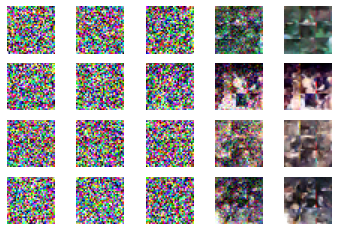

In [27]:
reverse_diffusion(1000, image_shape=(3, 32, 32))

In [17]:
model.load_state_dict(torch.load('Diffusion.tar'))

In [13]:
dataloader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True, drop_last=False)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

mse = nn.MSELoss()

start_epoch = 0
EPOCHS = 100

10/100
Last Loss: 0.0663120374083519	Total Loss: 0.056729156790965504
Last Gradients Average: -1.1285600294286269e-06	Gradients Average Sum: -8.786657417658716e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

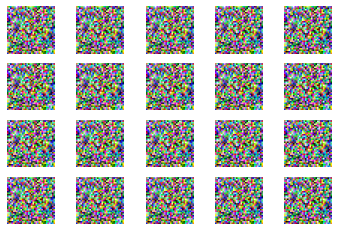

10/100
Last Loss: 0.09168541431427002	Total Loss: 0.0555779570806725
Last Gradients Average: -3.2080747587315273e-06	Gradients Average Sum: -1.6259187759715132e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

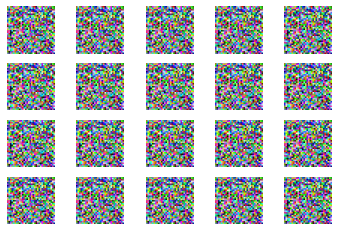

11/100
Last Loss: 0.055236440151929855	Total Loss: 0.055236440151929855
Last Gradients Average: 7.320913937292062e-07	Gradients Average Sum: 7.320913937292062e-07


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

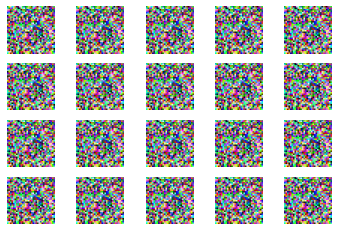

KeyboardInterrupt: 

In [14]:
for epoch in range(start_epoch, EPOCHS):

    epoch_loss = 0.
    gradients = []

    for i, image in enumerate(dataloader):

        model.zero_grad()

        time_step = torch.randint(low=0, high=1000, size=(image.size(0),), device=device)
        
        xt, noise = forward_diffusion(image.to(device), time_step)

        epsilont = model(xt, time_step)

        loss = mse(epsilont, noise)

        epoch_loss += loss.item()

        loss.backward()

        gradients.append(torch.mean(model.conv1.weight.grad))

        optimizer.step()

        if i % 1000 == 0:
            
            print(f'{epoch}/{EPOCHS}')
            print(f"Last Loss: {loss.item()}\tTotal Loss: {epoch_loss/(i+1)}")
            print(f"Last Gradients Average: {gradients[-1]}\tGradients Average Sum: {torch.tensor(gradients).sum()}")

            reverse_diffusion(1000, image_shape=(3, 32, 32))

In [ ]:
torch.save(model.state_dict(), 'Diffusion.tar')